In [18]:
import numpy as np, pylab,sys
import matplotlib.pyplot as plt
%matplotlib inline  

In [133]:
def get_stats(log_mass,conc, bins):
    median_conc = np.empty(len(bins)-1)
    quar1_conc = np.empty(len(bins)-1)
    quar2_conc = np.empty(len(bins)-1)

    for i in range(len(bins)-1):
        mass_index = np.where((log_mass>bins[i]) & (log_mass<bins[i+1]))
        conc_index = conc[mass_index]
        print np.size(mass_index)
        median_conc[i] = np.percentile(conc_index, 50)
        quar1_conc[i] = np.percentile(conc_index, 25)
        quar2_conc[i] = np.percentile(conc_index, 75)
    return median_conc,quar1_conc,quar2_conc

def enlarge_labels(ax,fsize):
    ticklabels_x = ax.get_xticklabels()
    ticklabels_y = ax.get_yticklabels()

    for label_x in ticklabels_x:
        label_x.set_fontsize(fsize)
        label_x.set_family('serif')
    for label_y in ticklabels_y:
        label_y.set_fontsize(fsize)
        label_y.set_family('serif')

In [76]:
density_filename = "../data/results/jc/MultiDark/Rvir_Mvir_fitparams_Multidark.dat"
velocity_filename = "../data/results/MDmini/velocity/results.csv"
mass_filename = "../data/results/MDmini/mass/results.csv"

In [77]:
data_density = np.loadtxt(density_filename)
data_velocity = np.loadtxt(velocity_filename, delimiter=",")
data_mass = np.loadtxt(mass_filename, delimiter=",")

In [78]:
# mass here is the virial mass
mass_density = data_density[:,1]*1.0E10
conc_density = data_density[:,0]/data_density[:,2]
log_mass_density = np.log10(mass_density)

particle_mass = 8.721E9

mass_velocity = data_velocity[:,7]*particle_mass
conc_velocity = data_velocity[:,4]
log_mass_velocity = np.log10(mass_velocity)

mass_mass  = data_mass[:,8]*particle_mass
conc_mass = data_mass[:,4]
log_mass_mass = np.log10(mass_mass)

(0.0, 50.0)

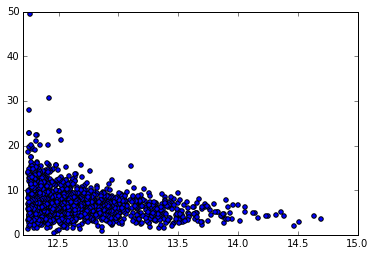

In [79]:
fig = plt.figure()
plt.scatter(np.log10(mass_density), conc_density)
plt.xlim([12.2,15.0])
plt.ylim([0.0,50.0])

In [171]:
n_bins = 7
log_mass_interval = np.linspace(12.25,14.5,n_bins)
mid_log_mass_interval = 0.5*(log_mass_interval[1:] + log_mass_interval[:-1])
mid_log_mass_interval =  log_mass_interval[:-1]

conc_median = np.ones((n_bins-1,3))
conc_up = np.ones((n_bins-1,3))
conc_down = np.ones((n_bins-1,3))

conc_median[:,0], conc_down[:,0], conc_up[:,0] = get_stats(log_mass_density,conc_density, log_mass_interval)
conc_median[:,1], conc_down[:,1], conc_up[:,1] = get_stats(log_mass_velocity,conc_velocity, log_mass_interval)
conc_median[:,2], conc_down[:,2], conc_up[:,2] = get_stats(log_mass_mass,conc_mass, log_mass_interval)


977
437
161
78
26
8
977
437
161
78
26
8
977
437
161
78
26
8


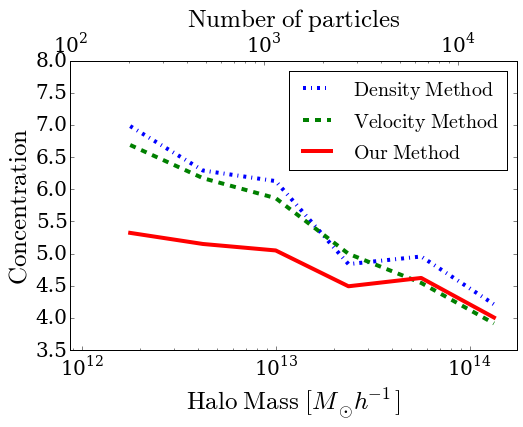

In [204]:
fig = plt.figure(figsize=(8.0,6.0))
ax = plt.axes()

enlarge_labels(ax,20)



estilos = ['-.', '--', '-']
colores = ['blue', 'green', 'red']
origen = ['$\mathrm{Density\ Method}$','$\mathrm{Velocity\ Method}$','$\mathrm{Our\ Method}$']
for i in range(3):
    ax.plot(10**mid_log_mass_interval,conc_median[:,i],colores[i],lw=4,linestyle=estilos[i], label=origen[i])

ax.legend(loc=1, borderaxespad=0.5, prop={'size':20})
plt.xlim([1E2*particle_mass,2E4*particle_mass])
plt.ylim([3.5,8])
#ax.plot(mid_log_mass_interval-np.log10(particle_mass),conc_median[:,0], lw=0)

ax2 = ax.twiny()
enlarge_labels(ax2,20)

plt.subplots_adjust(bottom=0.18, top=0.85)
ax2.set_xscale('log')
ax2.set_xlim([1E2,2E4])
ax2.set_xlabel('$\mathrm{Number\ of\ particles}$',fontsize=25)
ax.set_xscale('log')
ax.set_xlabel('$\mathrm{Halo\ Mass}\ [M_{\odot} h^{-1}]$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration}$',fontsize=25)
plt.savefig("concentration.pdf")

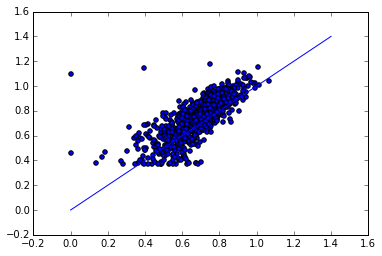

In [66]:
scatter(log10(conc_mass_sorted), log10(conc_velocity_sorted))
x = linspace(0.0,1.4, 100)
plot(x,x)

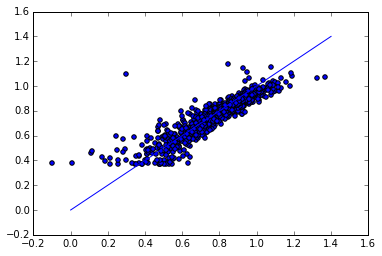

In [70]:
scatter(log10(conc_density_sorted), log10(conc_velocity_sorted))
plot(x,x)

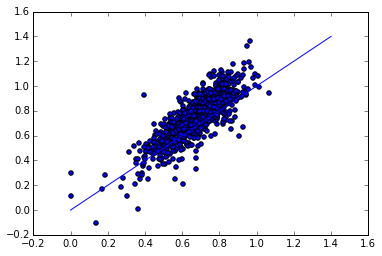

In [71]:
scatter(log10(conc_mass_sorted), log10(conc_density_sorted))
plot(x,x)